###Compreendendo o desafio

Estamos lidando com um problema de classificação: baseia-se em prever a categoria de uma observação dada. Aqui, procura-se estimar um “classificador” que gere como saída a classificação qualitativa de um dado não observado com base em dados de entrada (que abrangem observações com classificações já definidas).





###Bibliotecas utilizadas

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.svm import SVC

###Dataset:

Abrindo o arquivo que contém os dados de entrada para treinamento do modelo que iremos utilizar para fazer a predição.


In [14]:
df = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


###Análise dos dados

Analisemos a composição dos dados relativo a coluna failure_type

In [15]:
print("Porcentagem\n")
percentage = df['failure_type'].value_counts(normalize=True,sort=True)*100
print(percentage)

Porcentagem

No Failure                  96.520174
Heat Dissipation Failure     1.124944
Power Failure                0.944953
Overstrain Failure           0.779961
Tool Wear Failure            0.449978
Random Failures              0.179991
Name: failure_type, dtype: float64


Os dados de entrada são de maioria pertencentes a categoria 'No failure'. Logo, há um desbalanceamento. Isso faz com que tenhamos muitas informações a respeito da categoria mais incidente('No  failure'), e menos das minoritárias(outras cinco categorias).

###Histograma

Um histograma é uma espécie de gráfico de barras que demonstra uma distribuição de frequências. No histograma, a base de cada uma das barras representa uma classe e a altura representa a quantidade ou frequência absoluta com que o valor de cada classe ocorre.

O histograma de cada categoria são sobrepostos referentes as colunas. Assim, conseguimos acompanhar quais categorias se destacam referente a cada coluna nas diferentes faixas de valores.



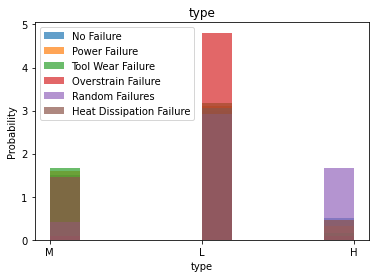

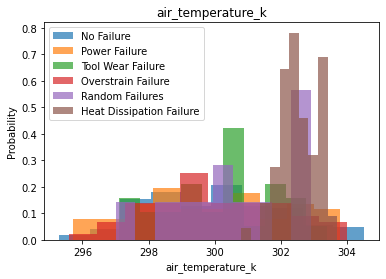

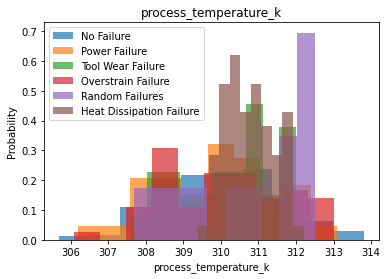

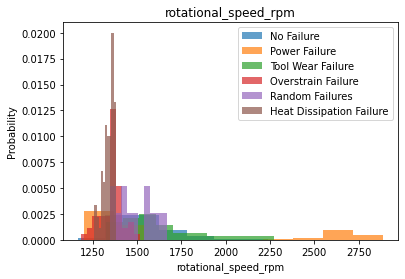

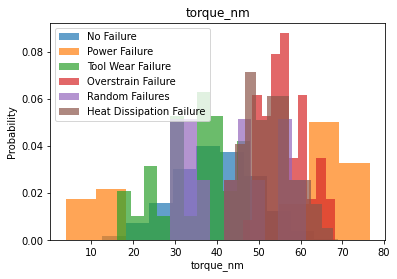

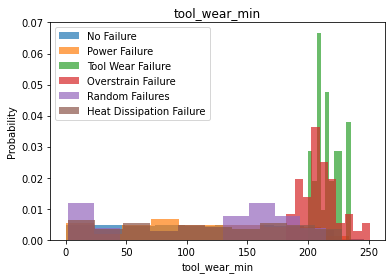

In [16]:
failureType = ('No Failure','Power Failure','Tool Wear Failure','Overstrain Failure',
'Random Failures','Heat Dissipation Failure')
cols = ("type","air_temperature_k","process_temperature_k","rotational_speed_rpm",
"torque_nm","tool_wear_min")

for label in cols:
	for types in failureType:
		plt.hist(df[df["failure_type"]==types][label],label=types, alpha=0.7, density=True)
	plt.title(label)
	plt.ylabel("Probability")
	plt.xlabel(label)
	plt.legend()
	plt.show()

###Datasets de treino e teste


Conversão para valores númericos da coluna type

In [17]:
dict_type = {"H":1,"L":2,"M":3}
df.type = df.type.map(dict_type)

Conjunto de dados para treino e teste onde 75% dos dados serão para treino e 25% para teste



In [ ]:
train,test = np.split(df.sample(frac=1), [int(0.75*len(df))])

Como será utilizado um método baseado em medidas de quão distantes estão os pontos de dados(SVM e kNN) iremos dimensionar os dados.

Visto que a distribuição das categorias é bastante desbalanceada será feito um oversampling para ajustar a distribuição de classes do conjunto de dados de teste.

In [18]:
def scale_dataset(dataframe, oversample=False):
	#duas primeiras colunas não agregam nos resultados
	X = dataframe[dataframe.columns[2:-1]].values
	#coluna com os resultados
	y = dataframe[dataframe.columns[-1]].values
	
	X = StandardScaler().fit_transform(X)
	
	if oversample:
		ros = RandomOverSampler()
		X, y = ros.fit_resample(X, y)
	
	data = np.hstack((X, np.reshape(y, (-1, 1))))
	
	return data, X, y


train, X_train, y_train = scale_dataset(train, oversample=True)
test, X_test, y_test = scale_dataset(test)


###Algoritmos

O algoritmo de SVM foi o selecionado de 4 algoritmos. 

1- Naive Bayes
> Motivo: desconsidera completamente qualquer correlação existente entre os atributos do dataset

2- Log Regression
> Motivo:A Regressão Logística é usada para estimar valores discretos de classes binárias.

3- kNN
> Motivo: os resultados foram inferiores em relação ao SVM.

4- SVM
> Apesar de o treinamento do SVM geralmente ser lento,exigem poucos ajustes e tende a apresentar bons resultado.



###Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.11      0.86      0.19        14
              No Failure       1.00      0.53      0.69      1615
      Overstrain Failure       0.18      0.93      0.30        14
           Power Failure       0.05      0.70      0.09        10
         Random Failures       0.00      0.25      0.01         4
       Tool Wear Failure       0.08      0.80      0.14        10

                accuracy                           0.53      1667
               macro avg       0.24      0.68      0.24      1667
            weighted avg       0.97      0.53      0.67      1667



##kNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.23      0.86      0.36        14
              No Failure       0.99      0.93      0.96      1615
      Overstrain Failure       0.41      0.86      0.56        14
           Power Failure       0.25      0.70      0.37        10
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.07      0.20      0.10        10

                accuracy                           0.92      1667
               macro avg       0.33      0.59      0.39      1667
            weighted avg       0.97      0.92      0.94      1667



###SVM

In [19]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
#accuracy = TP+TN/TP+TN+FN+FP
#precision = TP/TP+FP
#recall = TP/TP+FN
#f1 score = 2*(precision*recall/(precision+recall))
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.26      1.00      0.42        14
              No Failure       1.00      0.89      0.94      1615
      Overstrain Failure       0.56      1.00      0.72        14
           Power Failure       0.30      0.70      0.42        10
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.13      0.80      0.23        10

                accuracy                           0.89      1667
               macro avg       0.38      0.73      0.45      1667
            weighted avg       0.97      0.89      0.93      1667



O resultado da acurácia dá a impressão que o algoritmo escolhido perfomou bem. No entanto, ao analisar cuidadosamente os dados notaremos que ele identifica bem a categoria 'No failure' das demais. No entanto, a predição para as outras categorias apresentam um resultado bastante abaixo. 
Apesar do oversampling ter melhorado a predição o resultado não é satisfatório, uma vez que a identificação desses casos minoritários são o cerne do desafio a ser resolvido.

###Predição

Leitura dos dados para predição

In [27]:
df_teste = pd.read_csv("desafio_manutencao_preditiva_teste.csv")
df_teste.type = df_teste.type.map(dict_type)

Formatação dos dados e predição usando o modelo SVM



In [28]:
x_teste_pred = df_teste[df_teste.columns[2:]].values
x_teste_pred = StandardScaler().fit_transform(x_teste_pred)

y_teste_pred = svm_model.predict(x_teste_pred)

Criação do arquivo final predicted.csv

In [29]:
#gera a predição solicitada
df_predict = pd.DataFrame(data={'rowNUmber':np.array(range(1,3334)),'predictedValues':y_teste_pred})
df_predict.to_csv("predicted.csv",index=False)
df_predict.head()

,rowNUmber,predictedValues
0,1,No Failure
1,2,No Failure
2,3,No Failure
3,4,No Failure
4,5,No Failure
